In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
npg_palette2 = ["#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF"]
#sns.set_palette(npg_palette2)

import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

npg_palette = ["#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF"]
#sns.set_palette(npg_palette)

sns.set_style('white', {'axes.linewidth': 0.85})
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

In [2]:
species_list = ['dmel', 'dsim', 'dana',  'dvir', 'sleb']

In [ ]:
# load data
df = pd.read_csv('combined_res_singlecopy_ef.txt', sep = '\t')
df = df.dropna(subset=['log2FoldChange'])

In [ ]:
# load precalculated Pagel's lambda
df_lambda = pd.read_csv("pagels_lambda/pagel_lambda_by_gene_ef.csv")

In [6]:
ef_allspecies = pd.read_csv('gene_shared_all_1_ef_0709.csv')

cat_cols = [f"{sp}_cat" for sp in species_list]
expr_cols = [f"{sp}" for sp in species_list]
fold_cols = [f"{sp}_fold" for sp in species_list]

ef_allspecies['group'] = ef_allspecies[cat_cols].eq('Upregulated').any(axis=1).map({True: 'up', False: 'other'})
ef_allspecies['low_expression'] = ef_allspecies[expr_cols].lt(1).all(axis=1).map({True: 'low', False: 'other'})

df_merged = df_lambda.merge(ef_allspecies, left_on='gene', right_on='dmel_gene', how='left')

df_merged = df_merged[df_merged['low_expression'] == 'other']

In [ ]:
df_ef = pd.read_csv('combined_res_singlecopy_ef.txt', sep = '\t')
df_ef_dmel = df_ef[df_ef['species'] == 'dmel']
df_ef_dmel.drop_duplicates(subset=['gene'], inplace=True)

# separate upregulated and others, save the label in gene_group column
df_ef_dmel['gene_group'] = np.where(df_ef_dmel['gene_category'] == 'Upregulated', 'up', 'others')

In [ ]:
ef_allspecies_high_expr = ef_allspecies[ef_allspecies['low_expression'] == 'other']
df_ef_dmel_high = df_ef_dmel[df_ef_dmel['gene'].isin(ef_allspecies_high_expr['dmel_gene'])]

In [ ]:
import os
import random
def simulated_annealing(df):
    ## Simulated Annealing Parameters ##
    #nsteps = 100
    max_iter = 500
    
    K = 0.95 # after each iteration, temperature cools down
    T0 = 100. # initial temprature
    bins = np.arange(0,16.5,.5)
    l1norm_min_list = []
    l1norm_max_list = []

    up_gene_df = df[(df['gene_group'] == 'up')]
    other_gene_df = df[(df['gene_group'] == 'others')]
    print(f"up:{up_gene_df.shape[0]}\nothers:{other_gene_df.shape[0]}")
    
    num = len(up_gene_df)
    #print(num)

    #nsteps = min(30, max(10, num)) 
    nsteps = 30

    up_gene_list = up_gene_df['gene'].tolist()
    other_gene_list = other_gene_df['gene'].tolist()
    
    output_dir = f"genes_with_similar_expression"
    os.makedirs(output_dir, exist_ok=True)  

    for n in range(nsteps):
        list_dng = random.choices(up_gene_list,k=num)
        list_rng = random.choices(other_gene_list,k=num)
        list_rng0 = [g for g in list_rng]
        #dng_arr = [fbgn2exp[fbid] for fbid in list_dng]
        #rng_arr = [fbgn2exp[fbid] for fbid in list_rng]
        dng_arr = [up_gene_df[up_gene_df['gene'] == fbid]['baseMean'].values[0] for fbid in list_dng]
        rng_arr = [other_gene_df[other_gene_df['gene'] == fbid]['baseMean'].values[0] for fbid in list_rng]
        dng_hist,edges = np.histogram(dng_arr, bins=bins, range=None, density=True, weights=None)
        rng_hist,edges = np.histogram(rng_arr, bins=bins, range=None, density=True, weights=None)
        l1norm0 = sum(abs(rng_hist-dng_hist))
        l1norm_min = 1e9
        min_iter = 0
        list_min = []
        rng_hist_min = []
    
        if n==0:
            hist2plot_dng  = [d for d in dng_hist] # random permutated up genes
            hist2plot_rng0 = [d for d in rng_hist] # not expression matched other genes
        
        print(f"step {n}","iter 0",l1norm0)
        existed = {g:1 for g in list_rng}
        l1norm_max_list.append(l1norm0)
    
        # Actual Simulated Annealing #
        T = T0
        for it in range(max_iter):
            # decide which one to mutate #
            to_mut = random.randint(0,num-1)
            old_gene = list_rng[to_mut]
            gene_pool = [g for g in other_gene_df['gene']]# if g not in existed]
            #print(it, len(gene_pool))
            mut_gene = random.choice(gene_pool)
            
            ## mutate ##
            list_rng[to_mut] = mut_gene
            #existed[mut_gene] = 1
            #rng_arr = [fbgn2exp[fbid] for fbid in list_rng]
            #print(list_rng)
            
            rng_arr = [other_gene_df[other_gene_df['gene'] == fbid]['baseMean'].values[0] for fbid in list_rng]
            rng_hist,edges = np.histogram(rng_arr, bins=bins, range=None, density=True, weights=None)
            l1norm1 = sum(abs(rng_hist-dng_hist))
            
            ## accept if l1norm decrease ##
            paccpt = 1.0 if l1norm1<l1norm0 else np.exp(-(l1norm1-l1norm0)/T)
            p = random.uniform(0,1)
            if p < paccpt:
                l1norm0 = l1norm1
                if l1norm0 < l1norm_min:
                    l1norm_min = l1norm0
                    list_min = [g for g in list_rng]
                    rng_hist_min = [d for d in rng_hist]
                    min_iter = it
            else:
                ## reject change
                list_rng[to_mut] = old_gene
    
            T = T*K
    
        if n==0:
            hist2plot_rng1 = [d for d in rng_hist_min]
    
        print(f"step {n}",f"iter {min_iter}",l1norm_min)
        l1norm_min_list.append(l1norm_min)
    
        np.savetxt(f"genes_with_similar_expression/genes_randomly_selected_%d.txt"%(n+1),list_rng,fmt="%s")
        np.savetxt(f"genes_with_similar_expression/genes_randomly_selected_init_%d.txt"%(n+1),list_rng0,fmt="%s")
        np.savetxt(f"genes_with_similar_expression/denovo_genes_randomly_selected_%d.txt"%(n+1),list_dng,fmt="%s")

In [ ]:
df_combined = df_lambda.merge(df_ef_dmel_high, on='gene', how='left')

In [113]:
simulated_annealing(df_combined)

up:229
others:7953
step 0 iter 0 3.18158567774936
step 0 iter 495 1.608695652173913
step 1 iter 0 3.6000000000000005
step 1 iter 494 2.8021390374331556
step 2 iter 0 3.3333333333333335
step 2 iter 493 2.588235294117647
step 3 iter 0 2.8888888888888897
step 3 iter 440 1.1111111111111114
step 4 iter 0 3.12087912087912
step 4 iter 493 1.9285714285714284
step 5 iter 0 3.0769230769230766
step 5 iter 439 2.1960784313725488
step 6 iter 0 3.0588235294117645
step 6 iter 415 2.253968253968254
step 7 iter 0 3.652173913043478
step 7 iter 420 2.2937062937062933
step 8 iter 0 3.666666666666666
step 8 iter 351 1.6666666666666665
step 9 iter 0 3.333333333333334
step 9 iter 477 2.3555555555555556
step 10 iter 0 3.178571428571429
step 10 iter 468 1.9500000000000002
step 11 iter 0 3.5238095238095233
step 11 iter 456 1.766233766233766
step 12 iter 0 3.2857142857142865
step 12 iter 496 2.2368421052631575
step 13 iter 0 4.000000000000001
step 13 iter 492 1.688888888888889
step 14 iter 0 3.428571428571429
st

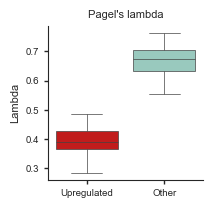

In [ ]:
custom_palette = [ "#DC0000FF", "#91D1C2FF"]

data = []
i = 1
while os.path.exists(f"genes_with_similar_expression/genes_randomly_selected_{i}.txt"):
    genes_sample = pd.read_csv(f'genes_with_similar_expression/genes_randomly_selected_{i}.txt', header=None)
    genes_denovo_sample = pd.read_csv(f'genes_with_similar_expression/denovo_genes_randomly_selected_{i}.txt', header=None)

    up_gene = df_combined[(df_combined['gene_group'] == 'up')]
    other_gene = df_combined[(df_combined['gene_group'] == 'others')]

    other_sample = other_gene.merge(genes_sample, left_on=f'gene', right_on=0, how='right')['lambda']
    up_sample = up_gene.merge(genes_denovo_sample, left_on=f'gene', right_on=0, how='right')['lambda']
    data.append({
            'gene_group': 'Upregulated',
            'lambda': up_sample.mean()
        })
    data.append({
        'gene_group': 'Other',
        'lambda': other_sample.mean()
    })
    i += 1

data_df = pd.DataFrame(data)

plt.figure(figsize=(2, 2))

ax = sns.boxplot(data=data_df, x='gene_group', y='lambda', hue='gene_group', palette=custom_palette, linewidth=0.5, flierprops={'markersize': 1})

plt.xlabel('')
plt.ylabel('Lambda', size=8)
plt.title('Pagel\'s lambda', size=8)
#plt.legend(title='Group')
ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1.1, 1), title="Group", fontsize=7, title_fontsize=8, markerscale=0.8, 
#                frameon=False)

sns.despine()
#plt.savefig("pagels_lambda_boxplot_ef.svg", dpi=300)

In [ ]:
from scipy.stats import mannwhitneyu

# get lambda values for each group
group1 = up_gene['lambda'].dropna()
group2 = other_gene['lambda'].dropna()

# Mann-Whitney U test
stat, p = mannwhitneyu(group1, group2, alternative='less')
print(f"Mann-Whitney U statistic: {stat:.2f}, p-value: {p:.3g}")

Mann-Whitney U statistic: 609500.50, p-value: 1.85e-18
